In [1]:
import sys, time, wmi, psutil
SYSTEM_INFO = wmi.WMI().Win32_OperatingSystem()[0]
"system: {0}, {1}, {2}".format(SYSTEM_INFO.Caption, SYSTEM_INFO.BuildNumber, SYSTEM_INFO.OSArchitecture) 
"memory: {}G".format(round(psutil.virtual_memory().total / 1024**3, 2))
"cpu: {}".format(psutil.cpu_count())
"python: {}".format(sys.version)
time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))

'system: Microsoft Windows 10 教育版, 18363, 64 位'

'memory: 15.86G'

'cpu: 4'

'python: 3.7.1 (default, Oct 28 2018, 08:39:03) [MSC v.1912 64 bit (AMD64)]'

'2020-08-13 22:14:58'

- **@author**: run_walker
- **@references**:
    1. [topological sort](https://en.wikipedia.org/wiki/Topological_sorting#Application_to_shortest_path_finding)
    2. [最长路径算法](https://www.jianshu.com/p/398e2697fd00)    

# 最短路径算法
对于加权有向无环图$G=(V,E)$，假设顶点集$V$的顺序已经为拓扑排序，入度为0的顶点全体记作$S$。维基百科的伪代码如下（稍作了改动）：
- Let $d$ be an array of the same length as $V$, this will hold the shortest-path distances from $S$. Set $d[s] = 0,~\forall s\in S$, all other $d[u]=+\infty$.
- Initial $p$ to an empty dict. Each $p[u]$ will hold the predecessor of $u$ in the shortest path from $s$ to $u$.
- Loop over the vertices $u$ as ordered in $V$, starting from $S$:
    * For each vertex $v$ directly following $u$ (i.e., there exists an edge from $u$ to $v$):
        - Let $w$ be the weight of the edge from $u$ to $v$.
        - Relax the edge: if $d[v] > d[u] + w$, set
            * $d[v] \leftarrow d[u] + w$,
            * $p[v] \leftarrow u$.
            
时间复杂度为$O(|E|+|V|)$

# 最长路径算法
对于加权有向无环图$G=(V,E)$，假设顶点集$V$的顺序已经为拓扑排序，入度为0的顶点全体记作$S$。算法伪代码如下：
- Let $d$ be an array of the same length as $V$, this will hold the longest-path distances from $S$. Set $d[s] = 0,~\forall s\in S$, all other $d[u]=-\infty$.
- Initial $p$ to an empty dict. Each $p[u]$ will hold the predecessor of $u$ in the longest path from $s$ to $u$.
- Loop over the vertices $u$ as ordered in $V$, starting from $S$:
    * For each vertex $v$ directly following $u$ (i.e., there exists an edge from $u$ to $v$):
        - Let $w$ be the weight of the edge from $u$ to $v$.
        - Relax the edge: if $d[v] < d[u] + w$, set
            * $d[v] \leftarrow d[u] + w$,
            * $p[v] \leftarrow u$.
            
类似于最短路径算法，只是在初始化时将所有距离置为负无穷，之后遍历时如果判断的方向变成小于。时间复杂度同样为$O(|E|+|V|)$。

## python实现

In [1]:
from collections import defaultdict


class GraphPath:
    """
    加权有向无环图的拓扑排序、最短及最长路径
    """

    def __init__(self, edges, in_degree_0=None):
        """

        :param edges: [(u1, v1, weight), ...]
        :param in_degree_0: 入度为0的顶点集合
        """
        self.nodes = set()  # 顶点集
        self.node_edges = defaultdict(set)  # 顶点的出边
        self.edge_weight = {}  # 边的权重
        for u, v, w in edges:
            self.nodes.update({u, v})
            self.node_edges[u].add(v)
            if v not in self.node_edges:
                self.node_edges[v] = set()
            self.edge_weight[u, v] = w
        #
        self.node_num = len(self.nodes)
        self.topo_order_list = None
        self.in_degree = None
        self.in_degree_0 = in_degree_0

    def gen_in_degree_0(self, S=None):
        """
        传入或者筛选入度为0的节点
        :param S: 如果不传入S的话根据基本信息进行筛选
        """
        if self.in_degree_0 is None:
            if S is None:
                self.in_degree = dict.fromkeys(self.nodes, 0)
                for u, vs in self.node_edges.items():
                    for v in vs:
                        self.in_degree[v] += 1
                self.in_degree_0 = {v for v, d in self.in_degree.items() if d == 0}
            else:
                self.in_degree_0 = S.copy()

    def topological_sort(self):
        """
        这里采取之前实验中表现最快的拓扑排序算法：不通过networkx模块的、基于dfs的、递归的实现
        :return:
        """
        if self.topo_order_list is None:
            #
            tem = set()
            per = set()
            L = []
            #
            def _dfs(u):
                if u in per: return  # 是否位于per的判断要先于tem
                if u in tem:
                    raise Exception(f"exists cycle, contains: {tem - per}")
                tem.add(u)
                for v in self.node_edges[u]:
                    _dfs(v)
                per.add(u)
                L.append(u)
            #
            for node in self.nodes:
                _dfs(node)
            self.topo_order_list = L[::-1]

    def cal_each_node_shortest_path_length(self, cal_path=False):
        """
        为每个节点计算最短路径的长度（及具体路径）
        :param cal_path: 是否计算具体路径，默认为False
        :return: dict
        """
        self.topological_sort()
        self.gen_in_degree_0()
        #
        distTo = {node: float("inf") for node in self.nodes}
        for s in self.in_degree_0:
            distTo[s] = 0
        edgeTo = {}
        # 松弛
        for v in self.topo_order_list:
            for w in self.node_edges[v]:
                temp = distTo[v] + self.edge_weight[v, w]
                if distTo[w] > temp:
                    distTo[w] = temp
                    edgeTo[w] = v
        # 求最短路径
        if cal_path:
            pathTo = {}
            for node in self.topo_order_list:
                path = [node]
                if node in edgeTo:
                    path = pathTo[edgeTo[node]] + path
                pathTo[node] = path
            return {'pathTo': pathTo, 'distTo': distTo}

        return {'distTo': distTo}

    def cal_each_node_longest_path_length(self, cal_path=False):
        """
        为每个节点计算最长路径的长度（及具体路径）
        （也可以为距离取相反数调用求最短路径的函数）
        :param cal_path: 是否计算具体路径，默认为False，不进行计算
        :return: dict
        """
        self.topological_sort()
        self.gen_in_degree_0()
        #
        distTo = {node: -float("inf") for node in self.nodes}
        for s in self.in_degree_0:
            distTo[s] = 0
        edgeTo = {}
        # 逆松弛
        for v in self.topo_order_list:
            for w in self.node_edges[v]:
                temp = distTo[v] + self.edge_weight[v, w]
                if distTo[w] < temp:
                    distTo[w] = temp
                    edgeTo[w] = v
        # 求最长路径
        if cal_path:
            pathTo = {}
            for node in self.topo_order_list:
                path = [node]
                if node in edgeTo:
                    path = pathTo[edgeTo[node]] + path
                pathTo[node] = path
            return {'pathTo': pathTo, 'distTo': distTo}

        return {'distTo': distTo}

In [2]:
edges = [('a', 'b', 1), ('a', 'c', 1), ('a', 'd', 1), ('b', 'c', 1),
         ('c', 'e', 1), ('d', 'f', 1), ('d', 'b', 1), ('f', 'c', 1)]

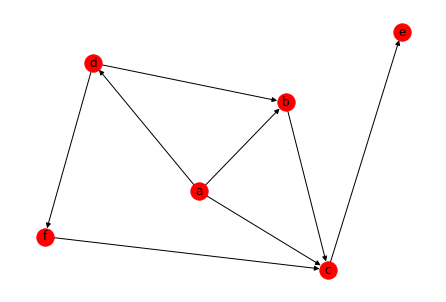

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

g = nx.DiGraph() 
g.add_weighted_edges_from(edges)
layout = nx.layout.spring_layout(g)
nx.draw(g, layout, with_labels=True, node_color="red")
# plt.show();

In [6]:
gp = GraphPath(edges, {'a'})
res = gp.cal_each_node_shortest_path_length(True)

res

{'pathTo': {'a': ['a'],
  'd': ['a', 'd'],
  'b': ['a', 'b'],
  'f': ['a', 'd', 'f'],
  'c': ['a', 'c'],
  'e': ['a', 'c', 'e']},
 'distTo': {'a': 0, 'd': 1, 'f': 2, 'b': 1, 'e': 2, 'c': 1}}

In [7]:
g.nodes

NodeView(('a', 'b', 'c', 'd', 'e', 'f'))

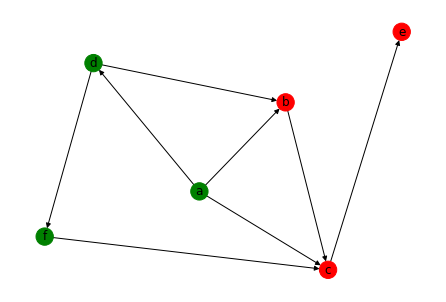

In [8]:
nx.draw(g, layout, with_labels=True, 
        node_color=['green' if x in res['pathTo']['f'] else 'red' for x in g.nodes])

In [9]:
gp.topo_order_list

['a', 'd', 'b', 'f', 'c', 'e']

In [10]:
gp.cal_each_node_longest_path_length()

{'distTo': {'a': 0, 'd': 1, 'f': 2, 'b': 2, 'e': 4, 'c': 3}}

# 实际应用

In [11]:
import pandas as pd

df = pd.DataFrame({'a': [1, 2, 3], 'b': [3, 4, 5]})

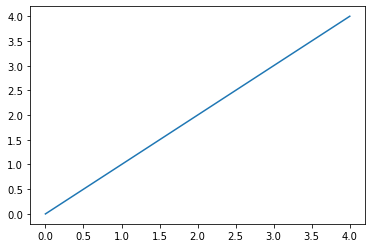

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(range(5), range(5));

## 优先级限制下的并行调度问题
1. 对于有$V$个任务的优先级调度问题，创建$2V+2$个顶点（1个起点$s$，1个终点$t$，每个任务2个顶点$v$和$v'$）
2. 每个任务添加一条从$v\rightarrow v'$的边，权重为任务所需时间；
3. 对于每条优先级限制$v\rightarrow w$，添加一条从$v$的结束顶点$v'$到$w$的起始顶点的权重为$0$的边，即$v'\rightarrow w$；
4. 每个任务$v$还要添加：$s\rightarrow v$的权重为$0$的边、$v'\rightarrow t$的权重为$0$的边。

经过上述处理后，每个任务$v$的开始时间就是从起点$s$到$v$的起始顶点的最长路径。

## 生产排程中的惩罚系数设置
**背景：**
* 在实际生产中，一个父件通常由数种不同的子件以各自的配比制成（例如：一台台式机通常由一个主机、一个显示屏、一个鼠标、一个键盘、两个音响组装构成），子件通常既可以用以自身的交货（例如有订单单独购买鼠标），也可以用来生产父件。
* 在制造行业中，经常需要对订单根据产品自身类型和需求类型及需求时间等特征进行优先级管理。例如：实际订单优先级高于预测订单；时间较近的订单优先级高于未来订单；对任一产品自身订单优先于自身作为零件的父项订单；原材料的订单低于其他所有组装件的订单；料本高的产品订单优先级高于料本低的产品订单。
* 通常通过调节惩罚系数来满足优先级的要求。比如说：我们需要所有具有父项-子项关系的item，子项的惩罚项都高于父项。

**解决方案：**
1. 首先，将所有父件-子件的关系建立成图（易知这一定是一个有向无环图），边的权值设置为正数，然后建立一个虚拟的根节点，令其指向所有的顶层父件（也即该件不存在父件），边的权值设置为顶层父件的惩罚系数。
2. 拓扑排序，然后计算根节点到所有顶点的最长路径，将次最长路径作为惩罚系数。

## 生成排程中的最晚开工日期（LPST）确定
需求的根本来源通常为订单，当现有库存不足以提供时，需要提前开工进行生产来满足交货日的需求。因此**需求**有两种：
1. Order，订单。
2. Csmp，生产父件对子件的消耗。

常见的**供应**通常有5种：
1. INV。排程开始时的初始库存。
2. WIP/PO。在排程期间新的到货。
3. MFG。生产出来的父件可以用于满足父件的需求。
4. Transit，转运。`plant1 -> plant2`，将item从工厂1转运到工厂2，满足发生在工厂2的需求。
5. Transfer，转移。`item1 -> item2`，多出现在不同品牌间，如一台电脑需要金士顿的内存条，可以用三星的内存条替代其进行生产。

其中前两种的supply是无法再追查下去的，而后两种supply可以继续向下搜寻至前三种。（例如，假设有一笔从plant1到plant2的Transit，那么在plant1内作为Transit_out，这是一条demand，由plant1内的INV进行提供；而在plant2内作为Transit_in，这又是一条supply，供应了plant2内的Order交付）。

假定我们已经确定了所有的supply-demand关系，易知这是一个有向无环图，我们可以由Order的交货时间来倒推MFG的最晚开工日期。类似地，先建立图结构，不同的是这张图并没有边的权值这一概念，而是每个节点有自己的属性（INV，WIP/PO，MFG，Transit，Transfer，Order）。所有的顶层父项也即订单需求，它们名义上的LPST也即它们的交货时间，再进行拓扑排序后依次向下进行传播，由父项的LPST和子项的属性，可以推出由于这一条边的制约子项的LPST，我们要取的就是这个节点最早的LPST。